## CAPM VS GRADIENT BOOSTING REGRESSOR
--------------
**Author: Collins Emezie Ugwuozor** . [Linkedin](https://www.linkedin.com/in/collins-ugwuozor)
. [Github](https://github.com/ClassicCollins)
. [Twitter](https://x.com/ClassicCollins2)

In the realm of asset price prediction and other economic forecast, there is always a need to strike a balance when making choices between the two modeling cultures: the structural model, exemplified by the Capital Asset Pricing Model (CAPM), and the predictive model, represented by machine learning techniques like Gradient Boosting Regressor (GBR). Each approach has its unique strengths and limitations. So, one should try as much as possible to bring in economics when making decision with predictive models as we as try not to oversimplify the structural models. Sometimes, this oversimplified models when filtering the noise end up filtering signals as well.

## Structural Model: CAPM
The Capital Asset Pricing Model (CAPM) is a cornerstone of traditional finance, rooted in economic theory. It posits that the expected return of a security is a function of its sensitivity to market risk (beta), the risk-free rate, and the expected market return. The formula is:

$$ E(R_i) = R_f + \beta_i (E(R_m) - R_f) $$

Where:
- \( $E(R_i)$ \) is the expected return of the asset 
- \( $R_f$ \) is the risk-free rate
- \( $\beta_i$ \) is the beta of the asset
- \( $E(R_m)$ \) is the expected return of the market

Structural models like CAPM impose specific functional forms and limited variables, often leading to models that generalize poorly outside their narrow design scope. Despite its theoretical elegance, CAPM’s explanatory power can be weak for asset price behaviors beyond the training dataset.
## Predictive Model: Gradient Boosting Regressor
On the other hand, the Gradient Boosting Regressor (GBR) is a powerful machine learning technique that prioritizes statistical explanatory power. GBR builds an ensemble of decision trees, optimizing for prediction accuracy through iterative refinement. The model does not rely on economic theory but focuses on improving data fit. The general formula for a GBR model is:
$$F(x) = \sum_{m=1}^{M} \gamma_m h_m(x)$$
Where:
- \( $F(x)$ \) is the final prediction
- \( M \) is the number of trees
- $h_m(x)$ is the $m$-th decision tree
- $ \gamma_m $ is the weight of the $ m $-th tree.

GBR models are flexible and can handle a wide range of variables, making them robust in out-of-sample predictions. However, they may lack the explicit economic interpretation that structural models provide and sometimes overfit.

In [1]:
import yfinance as yf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
# Step 1: Download Data for assets and market index
assets = ['AMD', 'LLY', 'MOH', 'AWK', 'NVDA']
s_n_p_index = '^GSPC'
data = yf.download(assets + [s_n_p_index], start='2020-01-01', end='2022-01-01')['Adj Close']

[*********************100%***********************]  6 of 6 completed


## CAPM for Price Prediction

In [13]:
# Step 2: Calculate Returns
returns = data.pct_change().dropna()
market_returns = returns[s_n_p_index]
asset_returns = returns[assets]

# Step 3: Calculate Beta for Each Asset
betas = {}
for asset in assets:
    X = sm.add_constant(market_returns)
    y = asset_returns[asset]
    model = sm.OLS(y, X).fit()
    betas[asset] = model.params[1]

# Step 4: Calculate Expected Returns for Each Asset (CAPM)
risk_free_rate = 0.015
market_risk_premium = market_returns.mean() * 252 - risk_free_rate
expected_returns = {asset: risk_free_rate + betas[asset] * market_risk_premium for asset in assets}

# Step 5: Calculate Portfolio Expected Return using Monte Carlo simulation for portfolio optimization
def monte_carlo_simulation(asset_returns, num_simulations):
    num_assets = asset_returns.shape[1]
    portfolio_weights = np.zeros((num_simulations, num_assets))
    portfolio_expected_return = np.zeros(num_simulations)
    portfolio_volatility = np.zeros(num_simulations)

    for i in range(num_simulations):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_weights[i] = weights

        portfolio_expected_return[i] = np.sum(asset_returns.mean() * weights) * 252
        portfolio_volatility[i] = np.sqrt(np.dot(weights.T, np.dot(asset_returns.cov() * 252, weights)))

    return portfolio_weights, portfolio_expected_return, portfolio_volatility

num_simulations = 1000
# Perform Monte Carlo simulation
portfolio_weights, portfolio_expected_return, portfolio_volatility = monte_carlo_simulation(asset_returns, num_simulations)

# Step 6: Predict Future Prices for Each Asset
current_prices = data.iloc[-1]
capm_predicted_prices = {asset: current_prices[asset] * (1 + expected_returns[asset]) for asset in assets}

# Step 7: Calculate Future Portfolio Value
capm_future_portfolio_value = np.sum([portfolio_weights[i] * capm_predicted_prices[asset] for i, asset in enumerate(assets)])


In [14]:
# Output
print("Betas:", betas)
print("Expected Returns:", expected_returns)
print("Portfolio Expected Return:", portfolio_expected_return.mean())
print("CAPM Predicted Prices:", capm_predicted_prices)
print("CAPM Future Portfolio Value:", capm_future_portfolio_value)

Betas: {'AMD': 1.2163926560066574, 'LLY': 0.7121372694836446, 'MOH': 0.982319148673952, 'AWK': 0.8282358231897847, 'NVDA': 1.4132821290180682}
Expected Returns: {'AMD': 0.2698335623308363, 'LLY': 0.16419234866712207, 'MOH': 0.2207952970747034, 'AWK': 0.18851492894273963, 'NVDA': 0.31108179376759715}
Portfolio Expected Return: 0.5797422871813608
CAPM Predicted Prices: {'AMD': 182.72904186895835, 'LLY': 312.61879354990145, 'MOH': 388.31055170100666, 'AWK': 212.70828252482423, 'NVDA': 38.49885127993421}
CAPM Future Portfolio Value: 1134.8655209246247


## Gradient Boosting Method for Price Prediction

In [15]:

# Step 8: Gradient Boosting Prediction
def gradient_boosting_prediction(data, asset):
    data['Returns'] = data[asset].pct_change().dropna()
    data['Market_Returns'] = data[s_n_p_index].pct_change().dropna()
    data = data.dropna()

    X = data[['Market_Returns']]
    y = data['Returns']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    future_market_return = market_returns.mean()
    predicted_return = model.predict([[future_market_return]])[0]

    current_price = data[asset].iloc[-1]
    predicted_price = current_price * (1 + predicted_return)
    
    return predicted_price

gb_predicted_prices = {asset: gradient_boosting_prediction(data, asset) for asset in assets}

# Step 9: Calculate Future Portfolio Value using Gradient Boosting predictions
gb_future_portfolio_value = np.sum([gb_predicted_prices[asset] for asset in assets])


In [16]:
# Output
print("Gradient Boosting Predicted Prices:", gb_predicted_prices)
print("Future Portfolio Value (Gradient Boosting):", gb_future_portfolio_value)

Gradient Boosting Predicted Prices: {'AMD': 149.41018628154947, 'LLY': 268.27274186727794, 'MOH': 319.3140272012931, 'AWK': 179.10815062997753, 'NVDA': 29.819107583192924}
Future Portfolio Value (Gradient Boosting): 945.924213563291


In [17]:
# Create a DataFrame to compare the predicted prices
comparison_df = pd.DataFrame({
    'Asset': list(gb_predicted_prices.keys()),
    'Gradient Boosting Predicted Prices': list(gb_predicted_prices.values()),
    'CAPM Predicted Prices': list(capm_predicted_prices.values())
})

# Add a row for future portfolio values
comparison_df.loc[len(comparison_df)] = ['PORTFOLIO_VALUE', gb_future_portfolio_value, capm_future_portfolio_value]

In [18]:
# Display the DataFrame
comparison_df

,Asset,Gradient Boosting Predicted Prices,CAPM Predicted Prices
0,AMD,149.410186,182.729042
1,LLY,268.272742,312.618794
2,MOH,319.314027,388.310552
3,AWK,179.108151,212.708283
4,NVDA,29.819108,38.498851
5,PORTFOLIO_VALUE,945.924214,1134.865521


In [19]:

# Step 1: Download Data for assets and market index
assets = ['AMD', 'LLY', 'MOH', 'AWK', 'FANG']
s_n_p_index = '^GSPC'
data = yf.download(assets + [s_n_p_index], start='2020-01-01', end='2022-01-01')['Adj Close']

# Step 2: Calculate Returns
returns = data.pct_change().dropna()
market_returns = returns[s_n_p_index]
asset_returns = returns[assets]

# Step 3: Split Data into Training and Testing Sets
train_size = int(len(returns) * 0.8)
train_returns = returns[:train_size]
test_returns = returns[train_size:]
train_market_returns = market_returns[:train_size]
test_market_returns = market_returns[train_size:]
train_asset_returns = asset_returns[:train_size]
test_asset_returns = asset_returns[train_size:]

# Step 4: Train CAPM Model and Predict Returns
betas = {}
for asset in assets:
    X = sm.add_constant(train_market_returns)
    y = train_asset_returns[asset]
    model = sm.OLS(y, X).fit()
    betas[asset] = model.params[1]

risk_free_rate = 0.015
market_risk_premium = train_market_returns.mean() * 252 - risk_free_rate
expected_returns = {asset: risk_free_rate + betas[asset] * market_risk_premium for asset in assets}

capm_predicted_returns = pd.DataFrame({asset: test_market_returns * betas[asset] for asset in assets})

# Step 5: Train Gradient Boosting Model and Predict Returns
def gradient_boosting_prediction(train_data, test_data, asset):
    # Prepare training data
    train_data = train_data[[asset, s_n_p_index]].dropna()
    train_data['Market_Returns'] = train_data[s_n_p_index]
    train_data['Returns'] = train_data[asset]

    X_train = train_data[['Market_Returns']]
    y_train = train_data['Returns']

    # Train the model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # Prepare test data
    test_data = test_data[[asset, s_n_p_index]].dropna()
    test_data['Market_Returns'] = test_data[s_n_p_index]

    X_test = test_data[['Market_Returns']]
    predicted_returns = model.predict(X_test)

    return predicted_returns

# Generating predicted returns for each asset
gb_predicted_returns = pd.DataFrame({asset: gradient_boosting_prediction(train_returns, test_returns, asset) 
                                     for asset in assets}, index=test_returns.index[:len(test_market_returns)])

# Step 6: Calculate Portfolio Performance
def calculate_portfolio_performance(predicted_returns, actual_returns):
    portfolio_weights = np.ones(len(assets)) / len(assets)
    predicted_portfolio_returns = predicted_returns.dot(portfolio_weights)
    actual_portfolio_returns = actual_returns.dot(portfolio_weights)
    
    predicted_cumulative_returns = (1 + predicted_portfolio_returns).cumprod() - 1
    actual_cumulative_returns = (1 + actual_portfolio_returns).cumprod() - 1
    
    return predicted_cumulative_returns, actual_cumulative_returns

# Calculate performance
capm_predicted_cumulative_returns, capm_actual_cumulative_returns = calculate_portfolio_performance(capm_predicted_returns, test_asset_returns)
gb_predicted_cumulative_returns, gb_actual_cumulative_returns = calculate_portfolio_performance(gb_predicted_returns, test_asset_returns)

# Output
#print("CAPM Predicted Cumulative Returns:", capm_predicted_cumulative_returns)
#print("CAPM Actual Cumulative Returns:", capm_actual_cumulative_returns)
#print("Gradient Boosting Predicted Cumulative Returns:", gb_predicted_cumulative_returns)
#print("Gradient Boosting Actual Cumulative Returns:", gb_actual_cumulative_returns)

[                       0%                       ]

[*********************100%***********************]  6 of 6 completed


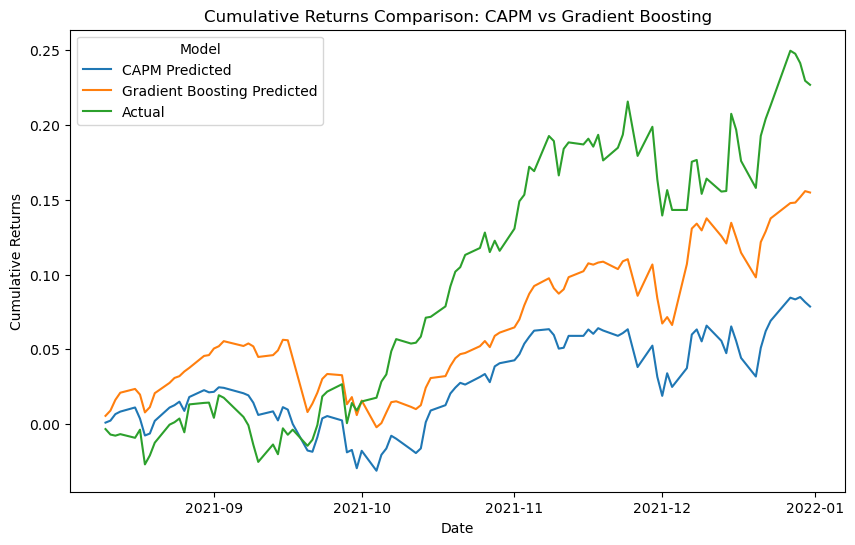

In [20]:
# Create a DataFrame for the cumulative returns for both CAPM and Gradient Boosting
cumulative_returns_df = pd.DataFrame({
    'CAPM Predicted': capm_predicted_cumulative_returns,
    'Gradient Boosting Predicted': gb_predicted_cumulative_returns,
    'Actual': gb_actual_cumulative_returns
})

# Reset the index for plotting (this creates a new column from the old index)
cumulative_returns_df = cumulative_returns_df.reset_index()
cumulative_returns_df.columns = ['Date'] + list(cumulative_returns_df.columns[1:])

# Melt the DataFrame to long format for easier plotting
cumulative_returns_melted = pd.melt(cumulative_returns_df, id_vars='Date', 
                                    value_vars=['CAPM Predicted', 
                                                'Gradient Boosting Predicted', 'Actual'],
                                    var_name='Model', value_name='Cumulative Returns')

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Returns', hue='Model', data=cumulative_returns_melted)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison: CAPM vs Gradient Boosting')
plt.legend(title='Model', loc='upper left')

# Show the plot
plt.show()

In [21]:
# Display the DataFrame
comparison_df

,Asset,Gradient Boosting Predicted Prices,CAPM Predicted Prices
0,AMD,149.410186,182.729042
1,LLY,268.272742,312.618794
2,MOH,319.314027,388.310552
3,AWK,179.108151,212.708283
4,NVDA,29.819108,38.498851
5,PORTFOLIO_VALUE,945.924214,1134.865521


## Conclusion
Both CAPM and GBR play crucial roles in stock price prediction. CAPM offers insights grounded in economic theory, while GBR provides robust predictive power. The choice between them depends on the specific needs of the analysis—whether the focus is on understanding economic mechanisms or achieving high prediction accuracy. Combining both models leads to a more accurate prediction.